**Importing Modules**

In [373]:
!pip3 install catboost -q
!pip3 install optuna -q
!pip3 install category_encoders

     |████████████████████████████████| 80 kB 5.1 MB/s 


In [297]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip -q

In [298]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import pandas_profiling as pf
%matplotlib inline


**Getting Datasets**

In [299]:
train=pd.read_csv('/content/drive/MyDrive/Datasets for ML/Pump it Up: Data Mining the Water Table/training_set_features.csv')
test=pd.read_csv('/content/drive/MyDrive/Datasets for ML/Pump it Up: Data Mining the Water Table/testing_set_features.csv')
label=pd.read_csv('/content/drive/MyDrive/Datasets for ML/Pump it Up: Data Mining the Water Table/training_set_labels.csv')

**Visualizing Data using Pandas Profiling**

In [300]:
profile =pf.ProfileReport(train, title="Pump-it-Up", explorative=True)
profile.to_notebook_iframe()

In [301]:
profile.to_file("Pump-It-Up_Report.html") #generating report to view in web browser

In [302]:
train.set_index('id',inplace=True)
label.set_index('id',inplace=True)
train_label = pd.merge(train, label, how = 'inner', left_index = True,right_index=True) #concating train and label 

In [303]:
train.reset_index(inplace=True)
label.reset_index(inplace=True)

In [304]:
print(train_label.shape, train.shape, test.shape)

(59400, 40) (59400, 40) (14850, 40)


**Concat the test and train for cleaning**

In [305]:
train_test = pd.concat([test.assign(ind="test"), train.assign(ind="train")])

In [306]:
train_test.shape

(74250, 41)

In [307]:
target_status_group = {'functional':0, 
                   'non functional': 2, 
                   'functional needs repair': 1} 
train_label['status_group'] = train_label['status_group'].replace(target_status_group)

**Showing Coorelation between num columns**

In [308]:
correlation_matrix = train_label.corr()
correlation_matrix.sort_values(ascending=False, by="status_group")

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status_group
status_group,-0.053702,-0.114029,0.004366,-0.014547,-0.005021,0.108640,0.065687,-0.017759,-0.043342,1.000000
region_code,-0.026813,-0.183521,0.034197,-0.221018,-0.020377,1.000000,0.678602,0.094088,0.031724,0.108640
district_code,-0.023599,-0.171233,0.151398,-0.201020,-0.004478,0.678602,1.000000,0.061831,0.048315,0.065687
longitude,0.022134,0.149155,1.000000,-0.425802,0.023873,0.034197,0.151398,0.086590,0.396732,0.004366
num_private,0.002944,0.007237,0.023873,0.006837,1.000000,-0.020377,-0.004478,0.003818,0.026056,-0.005021
latitude,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.221018,-0.201020,-0.022152,-0.245278,-0.014547
population,0.016288,0.135003,0.086590,-0.022152,0.003818,0.094088,0.061831,1.000000,0.260910,-0.017759
construction_year,0.067915,0.658727,0.396732,-0.245278,0.026056,0.031724,0.048315,0.260910,1.000000,-0.043342
amount_tsh,1.000000,0.076650,0.022134,-0.052670,0.002944,-0.026813,-0.023599,0.016288,0.067915,-0.053702
gps_height,0.076650,1.000000,0.149155,-0.035751,0.007237,-0.183521,-0.171233,0.135003,0.658727,-0.114029


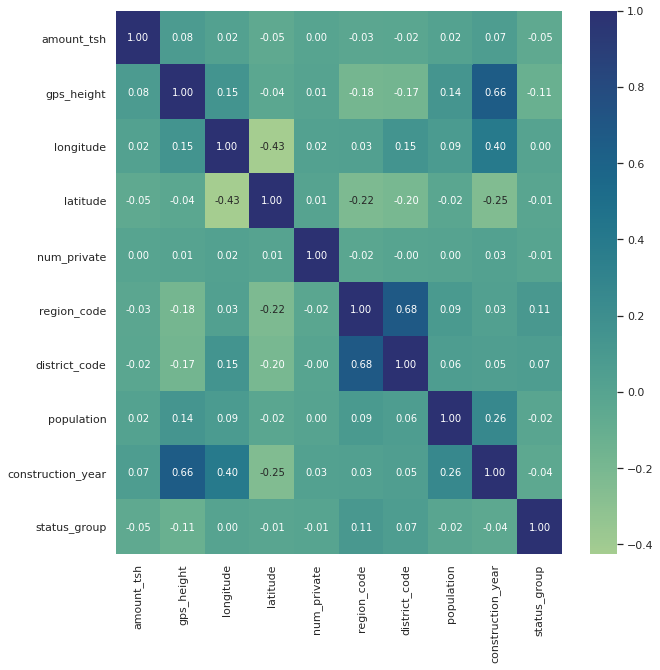

In [309]:
fig, ax = plt.subplots(figsize=(10, 10))
colormap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(correlation_matrix, cmap=colormap, annot=True, fmt=".2f")
plt.show()

# **Analysing Columns**

**Longitude and Latitude Column**

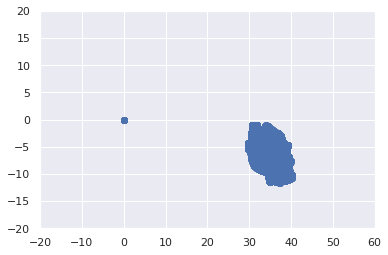

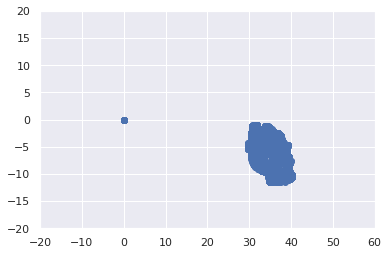

In [310]:
plt.scatter(train['longitude'],train['latitude']) #Plotting the Longitude and latitude Points on a X,Y plane 
plt.xlim(-20,60)
plt.ylim(-20,20)
plt.show()

plt.scatter(test['longitude'],test['latitude'])
plt.xlim(-20,60)
plt.ylim(-20,20)
plt.show()

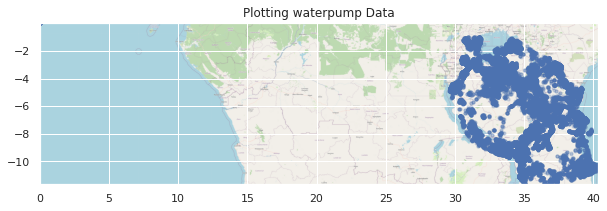

In [311]:
map= plt.imread('/content/drive/MyDrive/Datasets for ML/Pump it Up: Data Mining the Water Table/tanzania_map.png')# Plotting the points on a map
BBox = ((train.longitude.min(),   train.longitude.max(),      
         train.latitude.min(), train.latitude.max()))
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(train.longitude, train.latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting waterpump Data')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(map, zorder=0, extent = BBox, aspect= 'equal')

   There seems to be outliers in the Longitude column as well as Latitude Column. The Outlier Points in the Longitude column are in the ocean and the outlier points in the latitude column are outside tanzania and in other countries. So i used the mean values of longitude and latitude columns to change the outlier values to mean something.
   

In [312]:
train_test.loc[train_test['longitude']!=0].describe() #getting the mean value for longitude

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,71981.000000,71981.000000,71981.000000,71981.000000,71981.000000,71981.000000,71981.000000,71981.000000,71981.000000,71981.000000
mean,37117.739945,328.731381,686.650616,35.148358,-5.881503,0.476904,15.185091,5.728248,186.448493,1339.394090
std,21432.597850,2951.661960,693.280413,2.608924,2.808758,11.718023,17.775842,9.768536,477.341984,938.475708
min,0.000000,0.000000,-90.000000,29.607122,-11.649440,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18565.000000,0.000000,0.000000,33.277747,-8.632576,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37122.000000,0.000000,418.000000,35.007072,-5.173950,0.000000,12.000000,3.000000,35.000000,1988.000000
75%,55684.000000,30.000000,1330.000000,37.237383,-3.371872,0.000000,17.000000,5.000000,230.000000,2005.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-0.998464,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [313]:
train_test['longitude'].replace(to_replace = 0 , value =35.148358, inplace=True) 

In [314]:
train_test.loc[train_test['latitude']<=-1].describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,71973.000000,71973.000000,71973.000000,71973.000000,71973.000000,71973.000000,71973.000000,71973.000000,71973.000000,71973.000000
mean,37118.649660,328.767921,686.726939,35.148749,-5.882046,0.476957,15.184778,5.728106,186.469218,1339.542968
std,21432.735976,2951.823966,693.281142,2.608805,2.808443,11.718673,17.776805,9.769070,477.364464,938.421612
min,0.000000,0.000000,-90.000000,29.607122,-11.649440,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18565.000000,0.000000,0.000000,33.279483,-8.632675,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.000000,0.000000,418.000000,35.007394,-5.174422,0.000000,12.000000,3.000000,35.000000,1988.000000
75%,55685.000000,30.000000,1330.000000,37.237565,-3.372008,0.000000,17.000000,5.000000,230.000000,2005.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-1.000585,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [315]:
train_test['latitude'].replace(to_replace = -0.00000002 , value =-5.882046, inplace=True) #getting the mean value for latitude and change it

*1. For changing the value of a range use mask eg:* 

train_test['latitude'] = train_test['latitude'].mask(train_test['latitude'] >15, 0) 

In [316]:
 np.testing.assert_array_equal(len(train_test.loc[train_test['latitude']==-0.00000002]), 
                              0)

**Installer Column**

In [317]:
train_test['installer'].isnull().sum()

4532

In [318]:
train_test['installer'].fillna(value='Unknown',inplace=True) #filling the missing values as unknown
train_test['installer'].replace(to_replace = '0', value ='Unknown' , inplace=True) #changing 0 as Unknown Installer
train_test['installer'].value_counts().head(100).sum() #cardinaity is high so to reduce it check the total entries with 100

59128

In [319]:
#Replacing Spelling Mistakes with the correct value
train_test['installer'].replace(to_replace = ('District Water Department', 'District water depar','Distric Water Department'),
                        value ='District water department' , inplace=True)

train_test['installer'].replace(to_replace = ('FinW','Fini water','FINI WATER'), value ='Fini Water' , inplace=True)
train_test['installer'].replace(to_replace = 'JAICA', value ='Jaica' , inplace=True)

train_test['installer'].replace(to_replace = ('COUN', 'District COUNCIL', 'DISTRICT COUNCIL','District Counci', 
                                      'District Council','Council','Counc','District  Council','Distri'),
                                    value ='District council' , inplace=True)

train_test['installer'].replace(to_replace = ('RC CHURCH', 'RC Churc', 'RC','RC Ch','RC C', 'RC CH','RC church', 
                                      'RC CATHORIC',) , value ='RC Church' , inplace=True)

train_test['installer'].replace(to_replace = ('Central Government','Tanzania Government',
                                       'central government','Cental Government', 'Cebtral Government', 
                                      'Tanzanian Government','Tanzania government', 'Centra Government' ,
                                      'CENTRAL GOVERNMENT', 'TANZANIAN GOVERNMENT','Central govt', 'Centr', 
                                      'Centra govt') , value ='Central government' , inplace=True)

train_test['installer'].replace(to_replace = ('World vision', 'World Division','World Vision'),
                                        value ='world vision' , inplace=True)

train_test['installer'].replace(to_replace = ('Unisef','UNICEF'),value ='Unicef' , inplace=True)
train_test['installer'].replace(to_replace = 'DANID', value ='DANIDA' , inplace=True)

train_test['installer'].replace(to_replace = ('villigers', 'villager', 'villagers', 'Villa', 'Village', 'Villi', 
                                      'Village Council','Village Counil', 'Villages', 'Vill', 'Village community', 
                                      'Villaers', 'Village Community', 'Villag','Villege Council', 'Village council',
                                      'Village  Council','Villagerd', 'Villager', 'Village Technician',
                                      'Village Office','Village community members','VILLAGERS','VILLAGE COUNCIL','VILLAG',
                                      'VILLAGER','VILLAGE','village council', 'Villegers'),
                                        value ='villagers' , inplace=True)


train_test['installer'].replace(to_replace =('Commu','Communit','commu','COMMU', 'COMMUNITY') ,
                                        value ='Community' , inplace=True)

train_test['installer'].replace(to_replace = ('GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM','GOVERN','Gover','Gove',
                                      'Governme','Governmen' ) ,value ='Government' , inplace=True)

train_test['installer'].replace(to_replace = 'Hesawa' ,value ='HESAWA' , inplace=True)
train_test['installer'].replace(to_replace = ('Colonial Government') , value ='Colonial government' , inplace=True)
train_test['installer'].replace(to_replace = ('Government of Misri') , value ='Misri Government' , inplace=True)
train_test['installer'].replace(to_replace = ('Italy government') , value ='Italian government' , inplace=True)
train_test['installer'].replace(to_replace = ('British colonial government') , value ='British government' , inplace=True)
train_test['installer'].replace(to_replace = ('Concern /government') , value ='Concern/Government' , inplace=True)
train_test['installer'].replace(to_replace = ('Village Government','Village govt','Village Govt',) , value ='Village government' , inplace=True)
train_test['installer'].replace(to_replace = ('Government and Community') , value ='Government /Community' , inplace=True)
train_test['installer'].replace(to_replace = ('Central government /RC') , value ='RC church/Central Gover' , inplace=True)
train_test['installer'].replace(to_replace = ('Government /TCRS','Government/TCRS') , value ='TCRS /Government' , inplace=True)
train_test['installer'].replace(to_replace = ('ADRA /Government') , value ='ADRA/Government' , inplace=True)

In [320]:
uniq=train_test['installer'].unique() #cardinaity is high so to reduce it check the total entries with 100
matching = [s for s in uniq if "ViL" in s]
matching

['ViLLAGE COUNCIL']

In [321]:
train_test['installer'].value_counts().head(20)

DWE                   21751
Unknown                5516
Government             3337
Community              2112
DANIDA                 1995
HESAWA                 1749
RWE                    1498
District council       1449
Central government     1359
KKKT                   1120
TCRS                    887
world vision            846
CES                     765
Fini Water              732
RC Church               586
TASAF                   504
LGA                     501
WEDECO                  496
Unicef                  421
AMREF                   398
Name: installer, dtype: int64

Still the cardinality is so high.So to reduce the cardinality i took the top 17 unique values and assigned other values as "others"

In [322]:
c_ins = ['DWE','Unknown','Government','Community','DANIDA','RWE','District council', 'Central government',
         'KKKT','HESAWA','TCRS', 'world vision', 'Fini Water', 'RC Church','villagers','LGA']

train_test.loc[~train_test["installer"].isin(c_ins), "installer"] = "Others"
train_test['installer'].describe()

count      74250
unique        17
top       Others
freq       28480
Name: installer, dtype: object

**funder Column**

---





In [323]:
print(train_test['funder'].isna().sum(), len(train_test.loc[train_test['funder']=='0']))

4504 980


In [324]:
train_test['funder'].fillna(value='Unknown',inplace=True) #filling the missing values as unknown
train_test['funder'].replace(to_replace = '0', value ='Unknown' , inplace=True) #changing 0 as Unknown funder
train_test['funder'].value_counts().head(100).sum() #cardinaity is high so to reduce it check the total entries with 100

59681

In [325]:
#Replacing Spelling Mistakes with the correct value
train_test['funder'].replace(to_replace = 'Dwspd' ,value ='Dwsp' , inplace=True)
train_test['funder'].replace(to_replace = ('W0rld  Bank') ,value ='World Bank' , inplace=True)
train_test['funder'].replace(to_replace = ('Tcrs.Tlc','Tcrst','Tcrs Kibondo') ,value ='Tcrs' , inplace=True)
train_test['funder'].replace(to_replace = ('Tanzania') ,value ='Government Of Tanzania' , inplace=True)
train_test['funder'].replace(to_replace = ('Germany Republi','Germany',) ,value ='Germany Republic' , inplace=True)

In [326]:
uniq=train_test['funder'].unique() #cardinaity is high so to reduce it check the total entries with 100
matching = [s for s in uniq if "Water" in s]


Like the Installer column this column is also with high cardinatlity. so took the first twenty distinct values with high occurance and changed other record's funder to "Others"

In [327]:
c_fund = ['Danida','Unknown','Government Of Tanzania','Hesawa','Rwssp','World Bank','Kkkt', 'World Vision',
         'Unicef','Tasaf','District Council', 'Dhv', 'Private Individual', 'Dwsp','Norad','Germany Republic',
         'Tcrs','Ministry Of Water','Water','Dwe']
    

train_test.loc[~train_test["funder"].isin(c_fund), "funder"] = "Others"
train_test['funder'].describe()

count      74250
unique        21
top       Others
freq       32901
Name: funder, dtype: object

**construction Year Column**

In [328]:
train_test['construction_year'].describe()

count    74250.000000
mean      1298.463650
std        952.349375
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

In [329]:
train_test['construction_year'].replace(to_replace = 0, value = 'missing', inplace=True)# changed the missing values as missing
train_label['construction_year'].replace(to_replace = 0, value = 'missing', inplace=True)

In [330]:
# dividing the construction year to decades to reduce cardinality

train_test['construction_year'].replace(to_replace = (1960,1961,1962,1963,1964,1965,1966,1967,1968,1969),
                        value ='60s' , inplace=True)
train_test['construction_year'].replace(to_replace = (1970,1971,1972,1973,1974,1975,1976,1977,1978,1979),
                        value ='70s' , inplace=True)
train_test['construction_year'].replace(to_replace = (1980,1981,1982,1983,1984,1985,1986,1987,1988,1989),
                        value ='80s' , inplace=True)
train_test['construction_year'].replace(to_replace = (1990,1991,1992,1993,1994,1995,1996,1997,1998,1999),
                        value ='90s' , inplace=True)
train_test['construction_year'].replace(to_replace = (2000,2001,2002,2003,2004,2005,2006,2007,2008,2009),
                        value ='00s' , inplace=True)
train_test['construction_year'].replace(to_replace = (2010,2011,2012,2013),
                        value ='10s' , inplace=True)

train_label['construction_year'].replace(to_replace = (1960,1961,1962,1963,1964,1965,1966,1967,1968,1969),
                        value ='60s' , inplace=True)
train_label['construction_year'].replace(to_replace = (1970,1971,1972,1973,1974,1975,1976,1977,1978,1979),
                        value ='70s' , inplace=True)
train_label['construction_year'].replace(to_replace = (1980,1981,1982,1983,1984,1985,1986,1987,1988,1989),
                        value ='80s' , inplace=True)
train_label['construction_year'].replace(to_replace = (1990,1991,1992,1993,1994,1995,1996,1997,1998,1999),
                        value ='90s' , inplace=True)
train_label['construction_year'].replace(to_replace = (2000,2001,2002,2003,2004,2005,2006,2007,2008,2009),
                        value ='00s' , inplace=True)
train_label['construction_year'].replace(to_replace = (2010,2011,2012,2013),
                        value ='10s' , inplace=True)

In [331]:
train_test['construction_year'].value_counts()

missing    25969
00s        19163
90s         9611
80s         6939
10s         6461
70s         5448
60s          659
Name: construction_year, dtype: int64

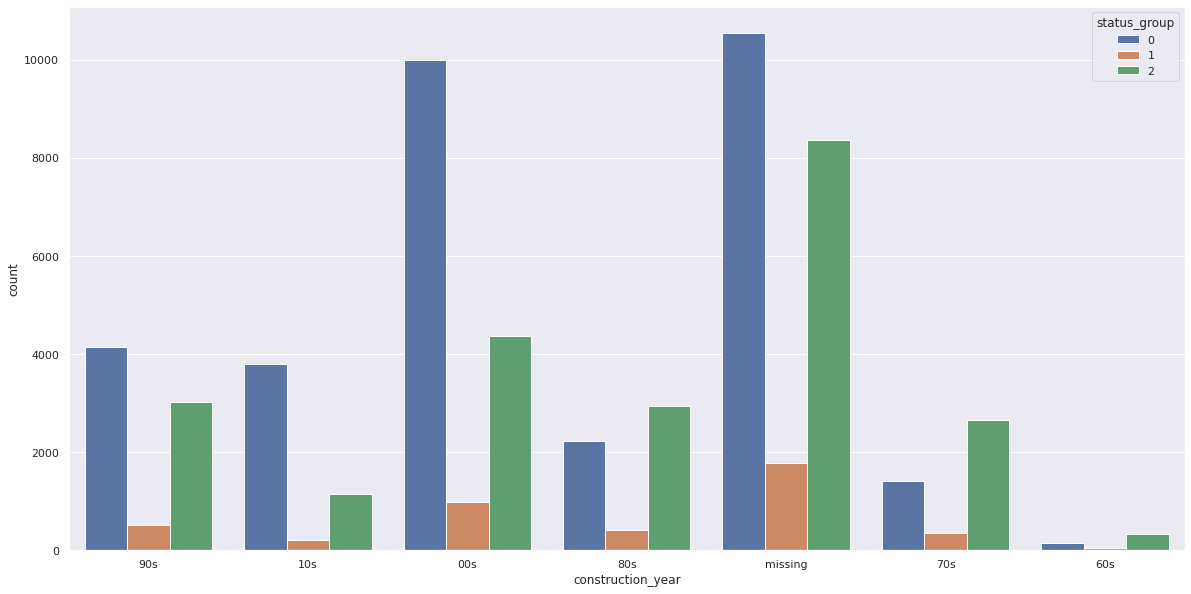

In [332]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='construction_year', hue="status_group", data=train_label)

**recorded_by column**

In [333]:
train_test['recorded_by'].value_counts()

GeoData Consultants Ltd    74250
Name: recorded_by, dtype: int64

This Column has only one distinct value so this column will be dropped.


**management / scheme_management / management_group columns**

In [334]:
train_test['scheme_management'].value_counts()

VWC                 45917
WUG                  6496
Water authority      3975
WUA                  3551
Water Board          3462
Parastatal           2124
Company              1341
Private operator     1326
Other                 996
SWC                   123
Trust                  92
None                    1
Name: scheme_management, dtype: int64

In [335]:
train_test['management'].value_counts()

vwc                 50624
wug                  8108
water board          3688
wua                  3118
private operator     2504
parastatal           2229
water authority      1123
other                1083
company               859
unknown               683
other - school        126
trust                 105
Name: management, dtype: int64

These two columns have almost the same information and as "scheme management" has null values i am dropping that column and having the "management" column.

In [336]:
train_test['management_group'].value_counts()

user-group    65538
commercial     4591
parastatal     2229
other          1209
unknown         683
Name: management_group, dtype: int64

In [337]:
train_test.groupby(['management_group','management']).count() 

id  ...    ind
management_group management               ...       
commercial       company             859  ...    859
                 private operator   2504  ...   2504
                 trust               105  ...    105
                 water authority    1123  ...   1123
other            other              1083  ...   1083
                 other - school      126  ...    126
parastatal       parastatal         2229  ...   2229
unknown          unknown             683  ...    683
user-group       vwc               50624  ...  50624
                 water board        3688  ...   3688
                 wua                3118  ...   3118
                 wug                8108  ...   8108

[12 rows x 39 columns]

**quantity, quantity_group columns**

In [338]:
train_test['quantity'].value_counts()

enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity, dtype: int64

In [339]:
train_test['quantity_group'].value_counts()

enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity_group, dtype: int64

both are almost same columns with same information so i decided to drop one of the columns

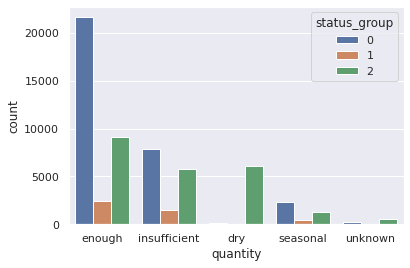

In [340]:
ax = sns.countplot(x='quantity', hue="status_group", data=train_label)

dry wells are seems to be totally non functional

**source , source_type , source_class columns**

In [341]:
train_test['source'].value_counts()

spring                  21216
shallow well            21140
machine dbh             13822
river                   11964
rainwater harvesting     2863
hand dtw                 1108
lake                      950
dam                       840
other                     261
unknown                    86
Name: source, dtype: int64

In [342]:
train_test['source_type'].value_counts()

spring                  21216
shallow well            21140
borehole                14930
river/lake              12914
rainwater harvesting     2863
dam                       840
other                     347
Name: source_type, dtype: int64

In [343]:
train_test['source_class'].value_counts()

groundwater    57286
surface        16617
unknown          347
Name: source_class, dtype: int64

These three seems to be hierachical data and source and source type provide the same. so i decided to drop the source type as source provides more detailed value

**water_quality , quality_group columns**

In [344]:
train_test['water_quality'].value_counts()

soft                  63505
salty                  6082
unknown                2345
milky                  1005
coloured                623
salty abandoned         423
fluoride                244
fluoride abandoned       23
Name: water_quality, dtype: int64

In [345]:
train_test['quality_group'].value_counts()

good        63505
salty        6505
unknown      2345
milky        1005
colored       623
fluoride      267
Name: quality_group, dtype: int64

same type of information though the water quality provides more explanation so i am dropping the  quality_group column

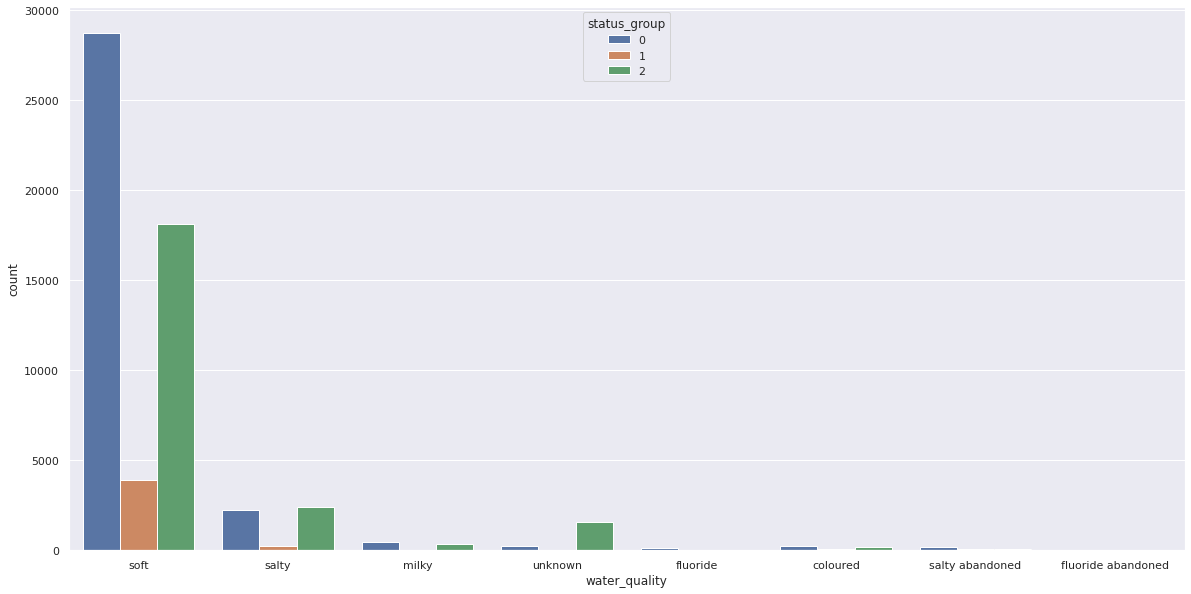

In [346]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='water_quality', hue="status_group", data=train_label)

**payment,payment_type columns**

In [347]:
train_test['payment'].value_counts()

never pay                31712
pay per bucket           11266
pay monthly              10397
unknown                  10149
pay when scheme fails     4842
pay annually              4570
other                     1314
Name: payment, dtype: int64

In [348]:
train_test['payment_type'].value_counts()

never pay     31712
per bucket    11266
monthly       10397
unknown       10149
on failure     4842
annually       4570
other          1314
Name: payment_type, dtype: int64

same columns so i decided to remove the 'payment' column

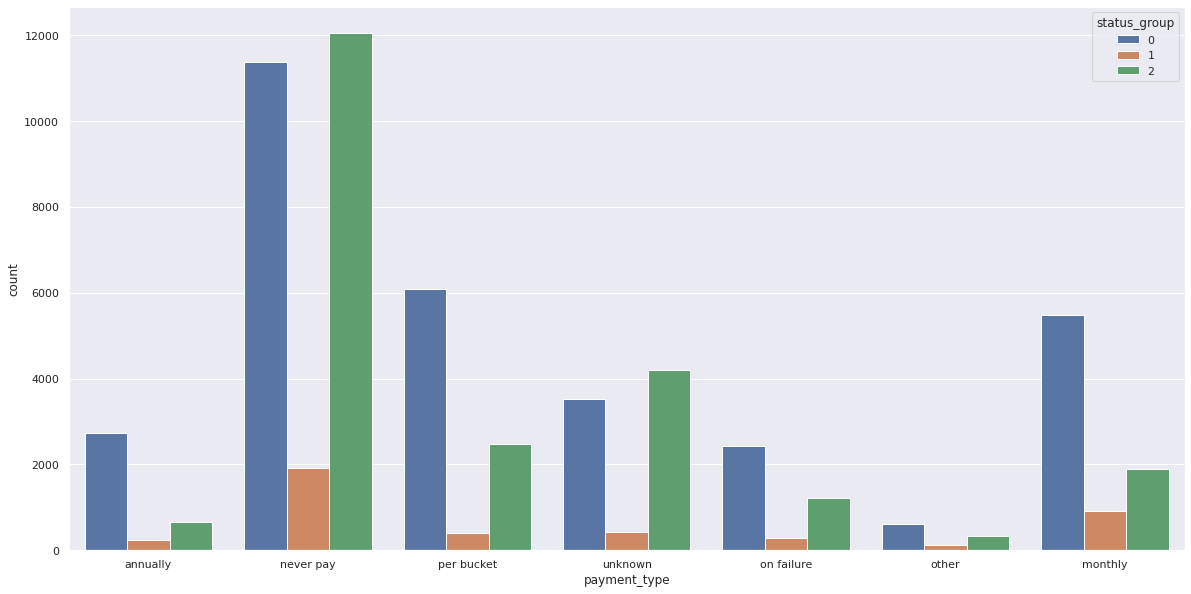

In [349]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='payment_type', hue="status_group", data=train_label)

**extraction_type, extraction_type_group**

In [350]:
train_test['extraction_type'].value_counts()

gravity                      33263
nira/tanira                  10205
other                         8102
submersible                   5982
swn 80                        4588
mono                          3628
india mark ii                 3029
afridev                       2208
ksb                           1790
other - rope pump              572
other - swn 81                 284
windmill                       152
india mark iii                 135
cemo                           108
other - play pump              101
walimi                          60
climax                          41
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [351]:
train_test['extraction_type_group'].value_counts()

gravity            33263
nira/tanira        10205
other               8102
submersible         7772
swn 80              4588
mono                3628
india mark ii       3029
afridev             2208
rope pump            572
other handpump       447
wind-powered         152
other motorpump      149
india mark iii       135
Name: extraction_type_group, dtype: int64

both contain almost same amount of information so decided to drop the extraction_type and extraction_type_class

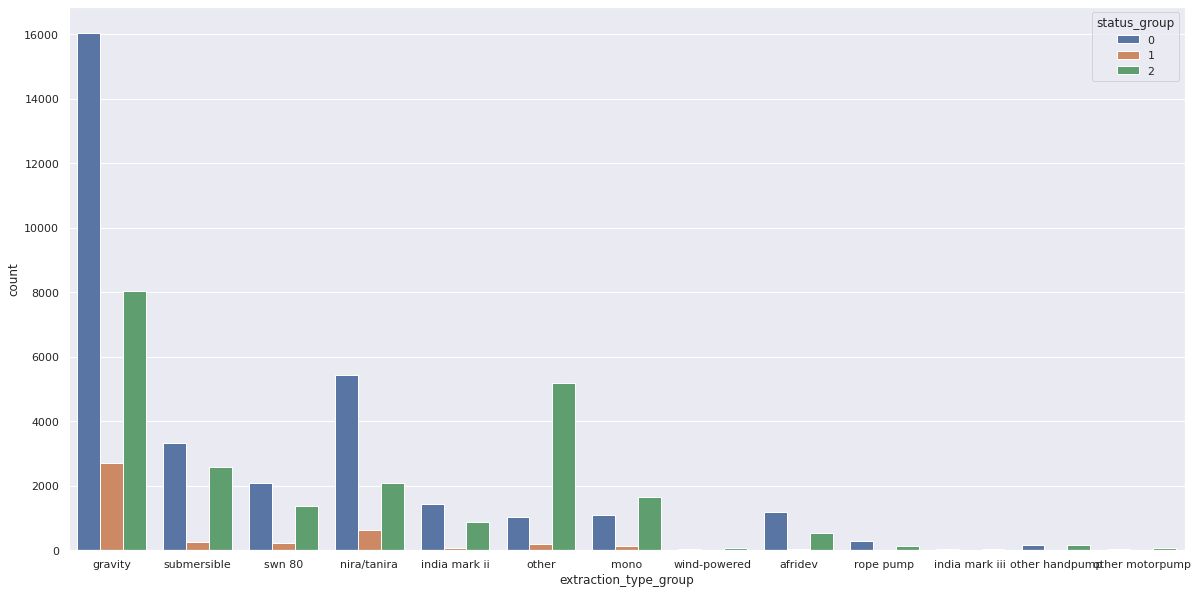

In [352]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='extraction_type_group', hue="status_group", data=train_label)


**waterpoint_type, waterpoint_type_group**

In [353]:
train_test['waterpoint_type'].value_counts()

communal standpipe             35628
hand pump                      21884
other                           8010
communal standpipe multiple     7611
improved spring                  959
cattle trough                    150
dam                                8
Name: waterpoint_type, dtype: int64

In [354]:
train_test['waterpoint_type_group'].value_counts()

communal standpipe    43239
hand pump             21884
other                  8010
improved spring         959
cattle trough           150
dam                       8
Name: waterpoint_type_group, dtype: int64

waterpoint_type is more detailed so decided to keep that and drop the waterpoint_type_group

In [355]:
#dropping similar columns and non functional columns
train_test.drop(columns=['scheme_management','quantity_group','source_type','quality_group','recorded_by',
                'payment','extraction_type_class','extraction_type', 'waterpoint_type_group','wpt_name','scheme_name','region_code'],inplace=True )

In [356]:
train_test.drop(columns=['num_private','date_recorded'],inplace=True )

In [357]:
len(train_test.columns)

27

**Filling Other Missing Values**

In [358]:
cat_col = ['funder', 'installer', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting',
       'permit', 'extraction_type_group', 'management', 'management_group', 
       'payment_type', 'water_quality','quantity',
        'source', 'source_class',
       'waterpoint_type','construction_year','district_code']

In [359]:
num_col = ['gps_height','longitude','latitude','population','amount_tsh']

In [360]:
len(cat_col)+len(num_col)

25

In [361]:
for col in (cat_col):
    train_test[col] = train_test[col].fillna(value='missing')

In [362]:
for col in num_col:
    train_test[col] = train_test[col].fillna(value=-1)

**Dividing the Test and Train after cleaning**

In [363]:
cleaned_test, cleaned_train = train_test[train_test["ind"].eq("test")], train_test[train_test["ind"].eq("train")]
cleaned_train=cleaned_train.drop(['ind'], axis=1)
cleaned_test=cleaned_test.drop(['ind'], axis=1)

In [364]:
cleaned_train.set_index('id', inplace=True)
label.set_index('id',inplace=True)
cleaned_train_label = pd.merge(cleaned_train, label, how = 'inner', left_index = True,right_index=True)

In [365]:
cleaned_train_label.reset_index(inplace=True)
cleaned_train.reset_index(inplace=True)
label.reset_index(inplace=True)

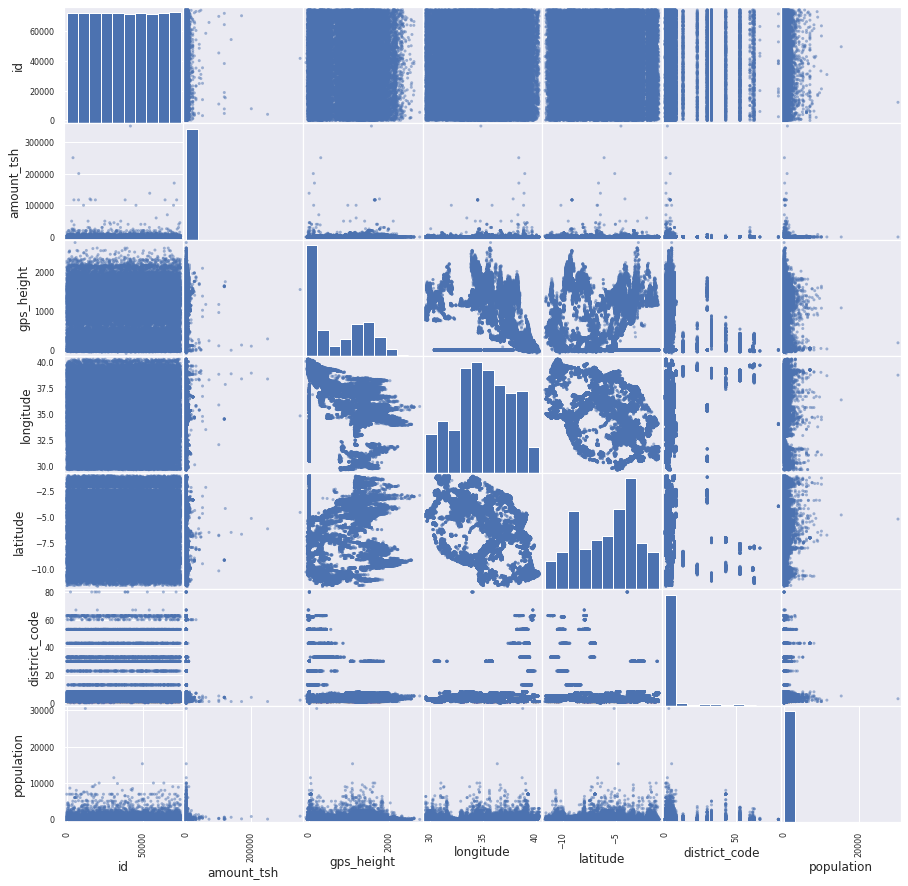

In [366]:
pd.plotting.scatter_matrix(cleaned_train,figsize=(15,15)) #pair-wise scatterplot
plt.show()

In [368]:
print(train.shape, cleaned_train.shape,test.shape, cleaned_test.shape, cleaned_train_label.shape)

(59400, 40) (59400, 26) (14850, 40) (14850, 26) (59400, 27)


In [369]:
num_cols = cleaned_train.select_dtypes('number').columns
len(num_cols)

7

In [370]:
cat_cols= cleaned_train.select_dtypes('object').columns
len(cat_cols)

19

# **Model Preparation and Tuning**

**Importing Needed Modules for Model**

In [374]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from catboost import Pool, cv
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler as re
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import optuna

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


**encoding the Categorical variables**

In [ ]:
encoder =TargetEncoder()

for c in cat_col:
    cleaned_train_label[c] = encoder.fit_transform(cleaned_train_label[c].values, cleaned_train_label["status_group"])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: Future

In [ ]:
# scaling numerical columns

scaler = re()


def scaleColumns(df, num_col):
    for col in num_col:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df

cleaned_train_label = scaleColumns(cleaned_train_label,[num_col])

In [ ]:
# assign X and y
used_cols = [c for c in cleaned_train_label.columns.tolist() if c not in ['status_group']]
X=cleaned_train_label[used_cols]
y=cleaned_train_label['status_group']
X

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,300.00,0.665385,3.236364e-01,0.773925,0.755028,-0.054981,-0.858738,0.502386,0.0,0.643461,0.336732,0.412354,0.413396,0.817264,0.430851,0.750000,0.390698,0.813295,2.014388e-01,0.890350,0.854389,0.700635,0.700635,0.700635,0.922631,0.849114,0.427512,0.427512,0.791294,0.791294,0.623034,0.623034,0.680454,0.680454,0.855505,0.677793,0.763032
1,8776,0.00,0.681818,3.773585e-01,0.780747,0.755028,-0.117562,0.640318,0.869880,0.0,0.908177,0.015129,1.069578,1.069578,0.814105,0.777933,0.746479,1.186047,0.946611,9.000923e-01,0.821708,0.487115,0.700635,0.700635,0.700635,0.701919,0.849114,1.026945,1.026945,0.791294,0.791294,0.857691,0.857691,0.655338,0.655338,0.791792,0.677793,0.763032
2,34310,1.25,0.790614,7.663413e-04,0.240288,0.621145,0.604634,0.314821,0.100269,0.0,0.744855,0.996016,0.692356,0.692356,0.699967,0.821429,0.200079,1.046512,0.813295,2.820837e-04,0.821708,0.633072,0.700635,0.700635,0.700635,0.922631,0.849114,0.598887,0.598887,0.791294,0.791294,0.623034,0.623034,1.192073,1.192073,0.791792,1.161396,0.763032
3,67743,0.00,1.162234,7.710501e-01,-0.080349,0.755028,0.872786,-1.111336,0.841162,0.0,1.184064,1.058824,1.321387,1.470011,1.338462,1.468354,1.625000,0.153488,0.813295,9.000923e-01,0.821708,1.128182,0.849916,0.881534,0.881534,0.922631,0.849114,1.026945,1.026945,0.791294,0.791294,1.943804,1.943804,0.976524,0.966775,0.855505,1.161396,0.763032
4,19728,0.00,0.991667,8.411616e-01,-0.279704,0.755028,-1.050520,0.702955,0.935355,0.0,0.908177,0.226223,0.866707,0.868231,0.819716,0.880674,0.307696,-0.116279,0.813295,9.000923e-01,0.821708,0.894249,0.700635,0.700635,0.700635,0.738152,0.820785,1.026945,1.026945,0.791294,0.791294,0.749136,0.749136,0.655338,0.655338,0.791792,0.677793,0.763032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,0.50,0.821622,2.344262e-01,0.637483,0.755028,0.528579,0.425172,0.841162,0.0,0.744855,0.039893,0.720712,0.720712,0.817264,0.252800,0.051724,0.465116,0.813295,0.000000e+00,0.821708,0.854389,0.700635,0.700635,0.700635,0.429935,0.849114,0.598887,0.598887,0.791294,0.791294,0.623034,0.623034,0.680454,0.680454,0.855505,0.677793,0.763032
59396,27263,235.00,0.015129,2.346394e-10,0.638999,0.755028,0.026576,-0.705953,0.841162,0.0,0.674398,0.000002,0.412354,0.413396,0.699967,0.358769,0.603774,0.144186,0.813295,8.631900e-11,0.821708,0.854389,0.700635,0.700635,0.700635,0.922631,0.849114,0.427512,0.427512,0.791294,0.791294,0.623034,0.623034,0.735851,0.796666,0.791792,0.677793,0.763032
59397,37057,0.00,1.025478,7.898212e-01,-0.279704,0.796618,-0.295811,-0.643689,1.066666,0.0,0.674398,0.226223,0.891571,0.891571,0.731080,0.792332,1.079545,-0.116279,0.813295,9.000923e-01,0.890350,0.894249,0.803270,0.803270,0.678597,0.922631,0.849114,0.567349,0.567349,0.425000,0.493088,0.623034,0.623034,0.976524,0.966775,0.855505,0.705455,0.705455
59398,31282,0.00,0.759146,1.002689e-01,-0.279704,0.755028,0.186428,-0.182459,0.841162,0.0,0.674398,1.125000,0.988187,0.988187,0.699967,1.086455,1.040000,-0.116279,0.813295,9.000923e-01,0.821708,0.894249,0.591734,0.591734,0.678597,0.922631,0.849114,1.026945,1.026945,0.791294,0.791294,0.857691,0.857691,0.953578,0.953578,0.855505,0.705455,0.705455


**Over-sampling for the Target imbalance but low accuracy for XGBclassifier so abandoned**

In [ ]:
# making over-sampling 

smt = SMOTE(sampling_strategy = 'auto', n_jobs = -1)

X_sampled, y_sample = smt.fit_sample(X, y)

print(y.value_counts())

y_sampled = pd.Series(y_sample) # converting from array to np.series to see value_counts

print(y_sampled.value_counts())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0    32259
2    22824
1     4317
Name: status_group, dtype: int64
2    32259
1    32259
0    32259
dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split( cleaned_train, label, test_size=0.3, random_state=68)

In [ ]:
X_train['public_meeting'].value_counts()

True       35708
False       3537
missing     2335
Name: public_meeting, dtype: int64

**Sequential Feature Selection to select the Model based features**

In [ ]:
ct = ColumnTransformer(
      transformers=[('cat', oe(), cat_col),('num',re(),num_col)])


In [ ]:
sfs2 = SFS(CatBoostClassifier(n_estimators=100, verbose=False,loss_function='MultiClass'), 
           k_features=37, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='accuracy',
           cv=5)

In [ ]:
sfs2 = sfs2.fit(ct.fit_transform(X_train), np.array(y_train.status_group).ravel())


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  4.9min finished

[2021-09-15 10:25:12] Features: 1/37 -- score: 0.646993746993747[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  5.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s finished

[2021-09-15 10:30:20] Features: 2/37 -- score: 0.697089947089947[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs

In [ ]:

fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

**Optuna for Hyperparameter tuning for CATBOOSTClassifier**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( cleaned_train, label, test_size=0.1, random_state=68)

In [ ]:
categorical_features_indices =np.where(X_train.dtypes != float)[0]

In [ ]:
train_dataset = Pool(data=X_train,
                     label=y_train.status_group,
                     cat_features = categorical_features_indices)

In [ ]:
def objective(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
         'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "MultiClass",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [ ]:
sampler = optuna.samplers.TPESampler(seed=68)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

**Model-CatBoostClassifier**

In [ ]:
final_model = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, loss_function='MultiClass'
                         )

In [ ]:
final_model.fit(X_train, y_train.status_group)

In [ ]:
predictions_h1 = final_model.predict(X_test)
predictions_h1

In [ ]:
final_model.fit(cleaned_train, label.status_group)

In [ ]:
print(final_model.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=2:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'iterations': 1000, 'sampling_frequency': 'PerTree', 'fold_permutation_block': 0, 'leaf_estimation_method': 'Newton', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'ctr_leaf_count_limit': 18446744073709551615, 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'max_ctr_complexity': 4, 'model_size_reg': 0.5, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=2:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType

In [ ]:
final_h1 = final_model.predict(cleaned_test)

In [ ]:
submission_df= pd.read_csv('/content/drive/MyDrive/Datasets for ML/Pump it Up: Data Mining the Water Table/SubmissionFormat.csv',)

In [ ]:
submission_df.head()

,id,status_group
0,50785,predicted label
1,51630,predicted label
2,17168,predicted label
3,45559,predicted label
4,49871,predicted label


In [ ]:
np.testing.assert_array_equal(test.index.values, 
                              submission_df.index.values)

In [ ]:
submission_df["status_group"]=final_h1

In [ ]:
submission_df.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [ ]:
submission_df.to_csv('your_submission.csv', index=False)

In [ ]:
from google.colab import files
files.download('your_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>